In [1]:
import numpy as np

## NL Dataset

In [2]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 8.17 MiB/s, done.


In [3]:
!ls ./multidim_conv/data/Wind_data_NL/

dataset.pkl  scaler.pkl


In [4]:
import pickle
with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [5]:
scaler

{'Features': ['Wind speed in 0.1m/s',
  'Wind direction in degrees (360 North, 90 East, 0 No wind)',
  'Temperature in 0.1C',
  'Dew Point in 0.1C',
  'Air Pressure in 0.1hpa',
  'Rain amount in 0.1mm'],
 'feature_min_train': array([ 0.000e+00,  0.000e+00, -1.950e+02, -2.170e+02,  9.681e+03,
        -1.000e+00]),
 'feature_max_train': array([  240.,   360.,   376.,   230., 10462.,   481.])}

- size of train data: 70128
- size of test data: 10872
- number of features: 6 (wind speed, wind direction, temperature, rain amount, air pressure, dew point)
- number of cities in the study: 7 

In [65]:
train_data = data['train']
test_data = data['test']
train_data.shape, test_data.shape

((70128, 7, 6), (10872, 7, 6))

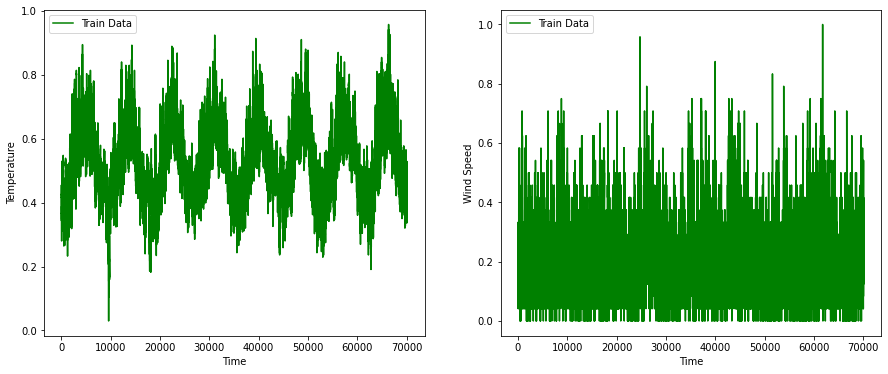

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(range(len(train_data[:, 0, 2])), train_data[:, 0, 2], 'g', label="Train Data")
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature')
ax1.legend(loc="upper left")
ax2.plot(range(len(train_data[:, 0, 0])), train_data[:, 0, 0], 'g', label="Train Data")
ax2.set_xlabel('Time')
ax2.set_ylabel('Wind Speed')
ax2.legend(loc="upper left")
plt.show()

In [66]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def buid_data(data, x_len, y_len):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
x_len = 10  # 4 hours X 2 (data recorded each 30minutes)
y_len = 1  # next step
x, y = buid_data(train_data[:, :, 0], x_len, y_len)
xtest, ytest = buid_data(test_data[:, :, 0], x_len, y_len)
x, y = x.reshape(70117, 7*10), y.reshape(70117, 7*1)
xtest, ytest = xtest.reshape(10861, 7*10), ytest.reshape(10861, 7*1)

print(x.shape)
print(y.shape)

xtrain = x[:60000]
ytrain = y[:60000]
xval = x[60000:]
yval = y[60000:]

(70117, 70)
(70117, 7)


In [67]:
"""MLP basic model"""
import torch
from torch import nn

class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(in_features=70, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=7),
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mlp().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [68]:
"""convert arrays to tensors"""
xtrain = torch.Tensor(xtrain).to(device)
ytrain = torch.Tensor(ytrain).to(device)
xval = torch.Tensor(xval).to(device)
yval = torch.Tensor(yval).to(device)
xtest = torch.Tensor(xtest).to(device)
ytest = torch.Tensor(ytest).to(device)

batch_size = 32
train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
val_data = torch.utils.data.TensorDataset(xval, yval)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(xtest, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [69]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss

"""Train loop"""
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    losses = []
    
    for x, y in train_iter:
        outputs = model(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    val_loss = validate(model) 
    
    if epoch % 5 == 0:
        print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)

Epoch:  1 , Train Loss:  0.0027832012358742454 , Val Loss:  0.003405368
Epoch:  6 , Train Loss:  0.001768731729996701 , Val Loss:  0.0018376793
Epoch:  11 , Train Loss:  0.0017211259060849746 , Val Loss:  0.0018695418
Epoch:  16 , Train Loss:  0.0016945203564440211 , Val Loss:  0.0018729925
Epoch:  21 , Train Loss:  0.0016573739505372942 , Val Loss:  0.001873509
Epoch:  26 , Train Loss:  0.0016371252267000575 , Val Loss:  0.0018359624
Epoch:  31 , Train Loss:  0.0016113790029659866 , Val Loss:  0.0017750636
Epoch:  36 , Train Loss:  0.0016009312262448173 , Val Loss:  0.001726702
Epoch:  41 , Train Loss:  0.00159069316641738 , Val Loss:  0.0017323238
Epoch:  46 , Train Loss:  0.0015845875396082799 , Val Loss:  0.0017318142


In [70]:
"""Test data predictions"""
model.eval()
y_preds = list()
y_true = list()

max_wind = scaler['feature_max_train'][0]
min_wind = scaler['feature_min_train'][0]

with torch.no_grad():
    for x, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
        y = y * max_wind + min_wind
        y_pred = y_pred * max_wind + min_wind
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)

In [71]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

RMSE:  10.141867
MAE:  7.6970253


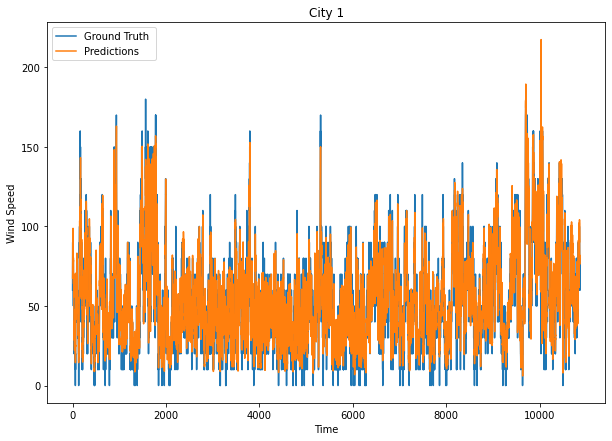

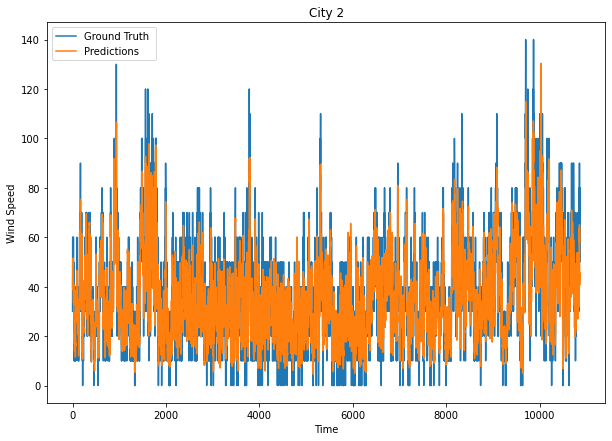

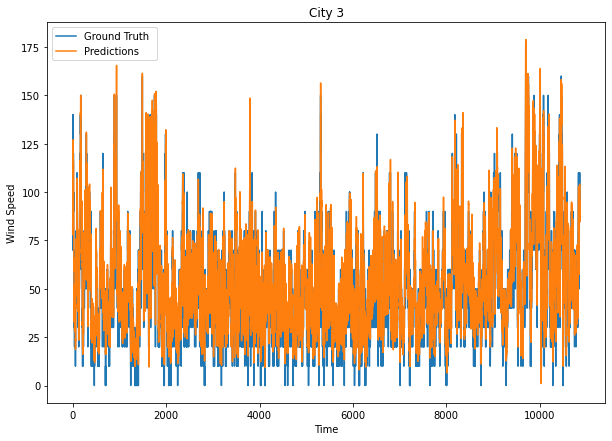

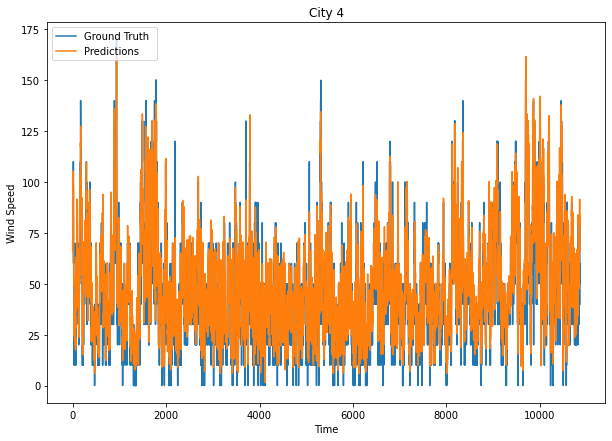

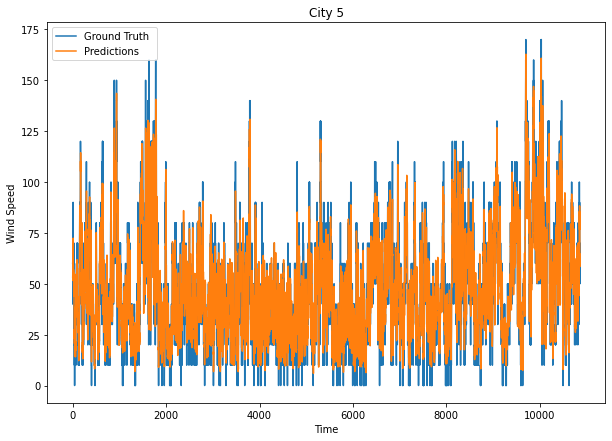

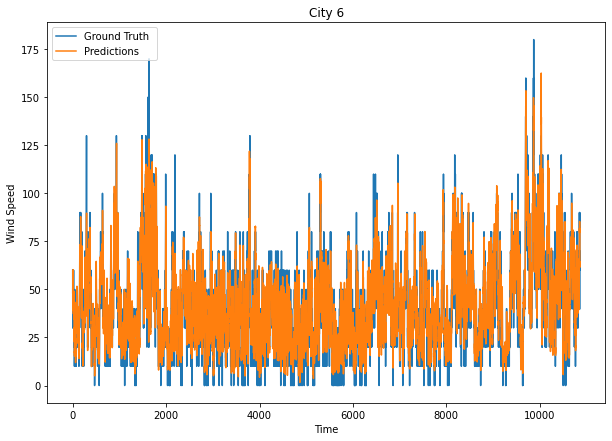

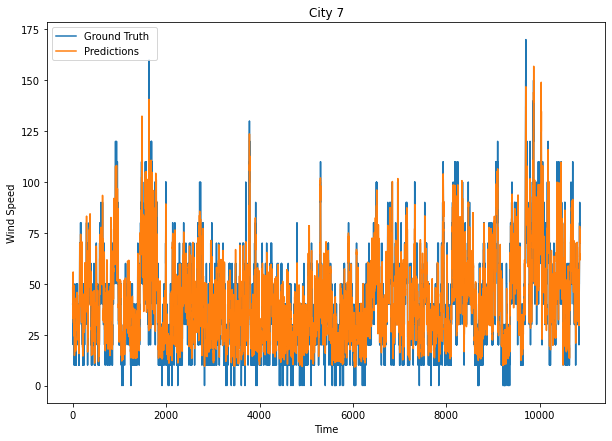

In [72]:
"""Visualization of windspeed predictions vs ground truth"""
for i in range(7):
    plt.figure(figsize=(10,7))
    plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
    plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
    plt.title('City '+str(i+1))
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.legend(loc="upper left")
    plt.show()

# References:

- Trebing, Kevin and Mehrkanoon, Siamak, 2020, Wind speed prediction using multidimensional convolutional neural networks